In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
torch.__version__

'2.6.0+cu124'

#### 1. Data (Preparing and loading)
1. Turn data into numbers
2. Build a model to learn the presentation as best as possible

In [2]:
weight, bias = 0.7, 0.3
X = torch.arange(
    start = 0, end = 1, step = 0.01
).unsqueeze(dim = 1)
X.shape
y = X * weight + bias
noise = torch.rand_like(y) * 0.1
y += noise

#### Split data into training and test sets
- Training set: The model learns from this data, amound of total data: 60 - 80%
- Validation set: The model gets tuned on this data, amound: 10 - 20%
- Testing set: The model get evaluated on this data to test what is has learned, amound: 10 - 20%

In [3]:
# Create train/valid/test split
train_size, val_size, test_size = int(len(y) * 0.6), int(len(y) * 0.2), int(len(y) * 0.2)
train_data = X[:train_size]
test_data = X[train_size:(train_size + test_size)]
val_data = X[len(test_data):]

train_label = y[:train_size]
test_label = y[train_size:(train_size + test_size)]
val_label = y[len(test_data):]

train_data.shape, test_data.shape, val_data.shape

(torch.Size([60, 1]), torch.Size([20, 1]), torch.Size([80, 1]))

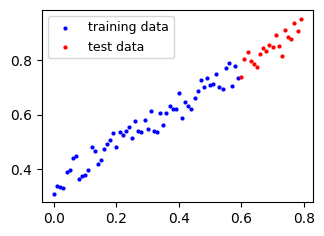

In [4]:
def plot(
        train_data, train_label,
        test_data, test_label, 
        # valid_data, valid_label, 
        pred = None
):
    plt.figure(figsize = (3.5, 2.5))

    # Plot training data in blue
    plt.scatter(train_data, train_label, c = 'b', s = 4, label = 'training data')

    plt.scatter(test_data, test_label, c = 'r', s = 4, label = 'test data')
    
    if pred is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.plot(np.concatenate((train_data, test_data)), pred, c="g", label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 9})

plot(train_data, train_label, test_data, test_label)

In [5]:
from torch import tensor

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype = torch.float32), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float32), requires_grad = True)
    def forward(self, x: torch.Tensor):
        return self.weight * x + self.bias


#### Pytorch module:
- torch.nn: Contains all of the building blocks for computational graph
- torch.nn.Parameter: Stores tensors that can be used with nn.Module. If require_grad = True then gradients will be calculated automatically.
- torch.nn.Module: The base class of all neural network modules, all the building blocks for neural networks are subclasses. If you are building a neural netword in PyTorch, your models should subclass nn.Module, requires a forward() method to be implemented.
- torch.optim: Contains various optimization algorithm which impove gradient descent and in turn reduce the loss.

In [6]:
torch.manual_seed(seed = 42)

model = LinearRegressionModel()

list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [7]:
model.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Make predictions with model
- Using torch.inference_mode()
- torch.inference_mode() is used when using a model for inference (making predictions). It turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes faster.
-  In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred. See this Tweet from PyTorch for more.

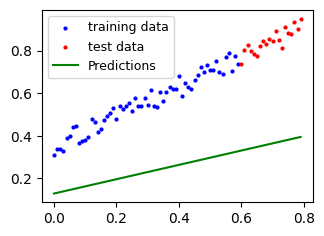

In [8]:
with torch.inference_mode():
    y_pred = model(np.concatenate((train_data, test_data)))
plot(
    train_data, train_label, test_data, test_label, pred = y_pred
)

- Loss function: Measure how wrong your model's prediction are compare to the truth labels. __Lower the better__
- Optimizer: Tells your model how to update its internal parameters to best lower the loss.

In [9]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)


#### Training loop
1. Forward pass: The model goes through all the training data once performing its forward() function calculations.
2. Calculate the loss: The model output are compared to the ground truth and evaluate to see how wrong they are.
3. Zero gradient: The optimizers gradient are set to zero so they can be recalculated for the specific training step.
4. Backpropagation: Compute the gradient of the loss with respect to every model paramater to be updated.
5. Update the optimizer: Update the parameters with requires_grad = True.

#### Testing loop
1. Forward pass
2. Calculate the loss
3. Calculate evaluation metrics

In [10]:
torch.manual_seed(42)

num_epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(num_epochs):
    model.train() # Put the model in training mode

    #1. Forward pass on training data using the forward method inside
    y_pred = model(train_data)

    #2. Calculate the loss
    loss = loss_fn(y_pred, train_label)

    #3. Zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model.eval()

    with torch.inference_mode():
        #1. Forward pass on test data
        test_pred = model(test_data)

        #2. Calculate loss on test_data
        test_loss = loss_fn(test_pred, test_label)

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epochs: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}")

Epochs: 0 | MSE Train Loss: 0.33203521370887756 | MSE Test Loss: 0.47252875566482544
Epochs: 10 | MSE Train Loss: 0.22333264350891113 | MSE Test Loss: 0.3520260751247406
Epochs: 20 | MSE Train Loss: 0.1158306822180748 | MSE Test Loss: 0.23253054916858673
Epochs: 30 | MSE Train Loss: 0.058005232363939285 | MSE Test Loss: 0.14620281755924225
Epochs: 40 | MSE Train Loss: 0.045101597905159 | MSE Test Loss: 0.11085265874862671
Epochs: 50 | MSE Train Loss: 0.043448615819215775 | MSE Test Loss: 0.10173449665307999
Epochs: 60 | MSE Train Loss: 0.0418693944811821 | MSE Test Loss: 0.09300060570240021
Epochs: 70 | MSE Train Loss: 0.04043150320649147 | MSE Test Loss: 0.0872974768280983
Epochs: 80 | MSE Train Loss: 0.03908088430762291 | MSE Test Loss: 0.0828932523727417
Epochs: 90 | MSE Train Loss: 0.03783782571554184 | MSE Test Loss: 0.07854489237070084


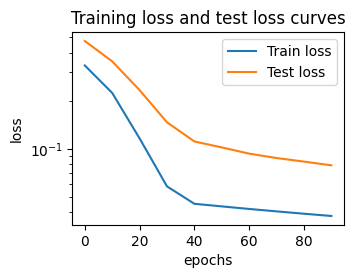

In [11]:
plt.figure(figsize = (3.5, 2.5))
plt.plot(epoch_count, train_loss_values, label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.yscale('log')
plt.title(label = "Training loss and test loss curves")
plt.legend()

In [12]:
print(model.state_dict())
print("weight = ", weight)
print("bias = ", bias)

OrderedDict([('weight', tensor([0.5107])), ('bias', tensor([0.4165]))])
weight =  0.7
bias =  0.3


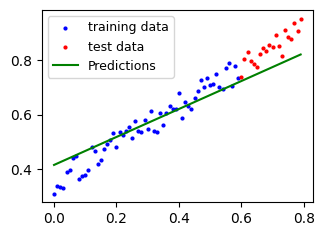

In [13]:
with torch.inference_mode():
    y_pred = model(np.concatenate((train_data, test_data)))
plot(
    train_data, train_label, test_data, test_label, pred = y_pred
)

#### Create data loader for getting batches

In [14]:
from torch.utils.data import TensorDataset, DataLoader

def get_data_loader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_iter = get_data_loader(test_data, test_label, batch_size = 5)

In [15]:
for X, y in test_iter:
    print("X: ", X)
    print("y: ", y)
    

X:  tensor([[0.6800],
        [0.7400],
        [0.7700],
        [0.7900],
        [0.6100]])
y:  tensor([[0.8309],
        [0.9094],
        [0.9361],
        [0.9513],
        [0.8043]])
X:  tensor([[0.7500],
        [0.7800],
        [0.6900],
        [0.6300],
        [0.7100]])
y:  tensor([[0.8840],
        [0.9041],
        [0.8564],
        [0.7970],
        [0.8926]])
X:  tensor([[0.6400],
        [0.6000],
        [0.7000],
        [0.6700],
        [0.7300]])
y:  tensor([[0.7861],
        [0.7363],
        [0.8457],
        [0.8438],
        [0.8139]])
X:  tensor([[0.7600],
        [0.7200],
        [0.6600],
        [0.6200],
        [0.6500]])
y:  tensor([[0.8772],
        [0.8505],
        [0.8235],
        [0.8290],
        [0.7756]])


In [16]:
class LinearRegressionModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(num_features, 1, bias = True))
    def forward(self, x):
        return self.net(x)

In [17]:
def create_linear_reg_data(weight, bias, data_size, num_features):
    X = torch.randn(size = (data_size, num_features))
    y = torch.matmul(X, weight) + bias
    noise = torch.randn_like(y)
    y += noise
    return X, y

def create_data_iter(weight, bias, train_size = 256, test_size = 128, batch_size = 32, valid_size = None, num_features = 5):
    X, y = create_linear_reg_data(weight, bias, train_size, num_features)
    train_iter = get_data_loader(X, y, batch_size)

    X, y = create_linear_reg_data(weight, bias, test_size, num_features)
    test_iter = get_data_loader(X, y, batch_size)

    if (valid_size is not None):
        X, y = create_linear_reg_data(weight, bias, valid_size, num_features)
        valid_iter = get_data_loader(X, y, batch_size)
        return train_iter, test_iter, valid_iter
    
    return train_iter, test_iter

weight = torch.tensor([1., 2., 3., 4., 5.]).reshape(5, 1)
bias = torch.tensor([5.])

train_iter, test_iter = create_data_iter(weight, bias)
for X, y in train_iter:
    print(X[0:2], y[0:2])
print("asdasdasd")
for X, y in train_iter:
    print(X[0:2], y[0:2])

tensor([[-0.8140, -0.7360, -0.8371, -0.9224,  1.8113],
        [ 1.3690, -0.6950, -0.3489, -0.4579, -1.2322]]) tensor([[ 4.0240],
        [-3.1147]])
tensor([[ 1.0514,  0.0075, -0.0774,  0.5397,  0.5655],
        [-0.0646,  3.4456,  0.3673, -0.3919,  0.1606]]) tensor([[10.8557],
        [12.7455]])
tensor([[-0.2016, -1.9768,  0.9275,  0.7894,  0.7825],
        [ 0.4463, -0.5218,  0.8302, -0.6920, -0.4720]]) tensor([[10.1254],
        [ 2.3513]])
tensor([[-6.4659e-02, -2.3021e-04,  5.6931e-01,  7.4762e-01,  2.1337e+00],
        [-3.3634e-02, -7.9826e-01, -2.6482e-01, -1.6661e-01,  2.5182e-01]]) tensor([[19.8351],
        [ 2.6208]])
tensor([[-0.8810,  0.3484, -1.1756, -0.0783, -0.9706],
        [-1.3667,  0.3298,  0.0176,  0.0782,  0.1932]]) tensor([[-4.6019],
        [ 6.5534]])
tensor([[ 1.2752,  1.2704, -0.0750, -2.2950, -1.3631],
        [ 0.0697, -1.6034, -0.4298,  0.5762,  0.6829]]) tensor([[-6.0951],
        [ 5.5129]])
tensor([[-1.8284, -0.1418, -0.2439, -0.7832, -0.2678],
     

In [18]:
import torch.optim.sgd

model = LinearRegressionModel(5)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

def train_epoch(model: nn.Module, train_iter, test_iter):
    model.train()
    train_loss = 0
    test_loss = 0
    num_train = 0
    for X, y in train_iter:
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().numpy()
        # print(len(y))
        num_train += len(y)

    model.eval()
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            test_loss = (loss.detach().numpy()) / len(y)
            break
    return train_loss / num_train, test_loss

def train(model: nn.Module, train_iter, test_iter, num_epochs):
    train_plot_data = []
    test_plot_data = []
    for epoch in range(num_epochs):
        train_loss, test_loss = train_epoch(model, train_iter, test_iter)
        train_plot_data.append(train_loss)
        test_plot_data.append(test_loss)
        if (epoch % 5 == 0):
            print(f"Epoch: {epoch} | L1Loss Train: {train_loss} | L1Loss Test: {test_loss}")
    
    return train_plot_data, test_plot_data
    
num_epochs = 25
train_plot_data, test_plot_data = train(model, train_iter, test_iter, num_epochs)    


Epoch: 0 | L1Loss Train: 0.24776619113981724 | L1Loss Test: 0.24218587577342987
Epoch: 5 | L1Loss Train: 0.15233839116990566 | L1Loss Test: 0.1263229101896286
Epoch: 10 | L1Loss Train: 0.06586691318079829 | L1Loss Test: 0.06737842410802841
Epoch: 15 | L1Loss Train: 0.025358097860589623 | L1Loss Test: 0.019180916249752045
Epoch: 20 | L1Loss Train: 0.02458079275675118 | L1Loss Test: 0.01782439649105072


In [19]:
print(list(model.parameters()))
print(weight)
print(bias)


[Parameter containing:
tensor([[0.9595, 1.9527, 3.1009, 4.0410, 4.9017]], requires_grad=True), Parameter containing:
tensor([4.8552], requires_grad=True)]
tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.]])
tensor([5.])


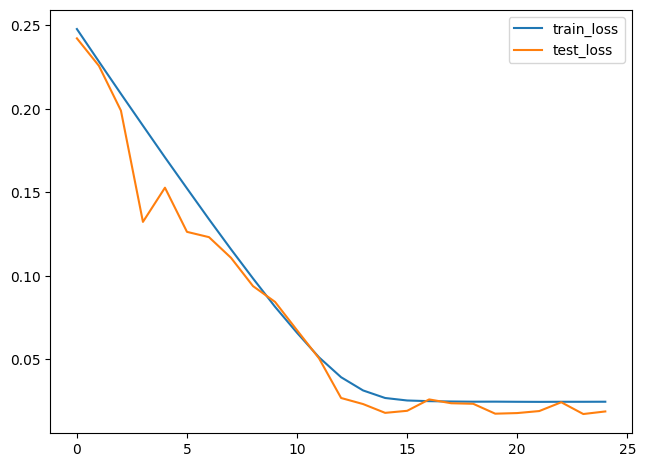

In [20]:
plt.figure(figsize = (7.5, 5.5))
plt.plot(np.arange(0, num_epochs), train_plot_data, label = "train_loss")
plt.plot(np.arange(0, num_epochs), test_plot_data, label = "test_loss")
plt.legend()
plt.show()